In [1]:
"""
XLM-RoBERTa Training - SIMPLIFIED APPROACH
===========================================

REMOVED:
- RandomOverSampler (doesn't work with text)
- Focal Loss (too aggressive)
- 2x class weight boost

KEPT:
- Balanced class weights (standard)
- Proper preprocessing
- Per-class monitoring

This is the CORRECT approach for imbalanced text classification.
"""

# ============================================================================
# SECTION 1: INSTALLATIONS & IMPORTS
# ============================================================================

!pip install transformers datasets accelerate -q
# !pip install imbalanced-learn scikit-learn -q
!pip install indic-transliteration emoji regex -q
!pip install huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not 

In [2]:
# """
# BETTER AUGMENTATION STRATEGY
# =============================

# Problem: Augmenting 58 → 400 creates too many low-quality copies
# Solution: Conservative augmentation + stronger regularization

# Key Changes:
# 1. Augment LESS (58 → 150, not 400)
# 2. Use DIVERSE augmentation techniques
# 3. Add STRONGER regularization
# 4. Earlier stopping (7 epochs max)
# """

# import numpy as np
# import pandas as pd
# import random
# from typing import List

# # ============================================================================
# # IMPROVED AUGMENTATION TECHNIQUES
# # ============================================================================

# def random_swap(text: str, n: int = 2) -> str:
#     """Swap word positions"""
#     words = text.split()
#     if len(words) < 2:
#         return text
#     new_words = words.copy()
#     for _ in range(min(n, len(words)//2)):
#         if len(new_words) >= 2:
#             idx1, idx2 = random.sample(range(len(new_words)), 2)
#             new_words[idx1], new_words[idx2] = new_words[idx2], new_words[idx1]
#     return ' '.join(new_words)


# def random_deletion(text: str, p: float = 0.15) -> str:
#     """Delete words with probability p"""
#     words = text.split()
#     if len(words) <= 2:
#         return text
#     new_words = [word for word in words if random.random() > p]
#     if len(new_words) == 0:
#         return random.choice(words)
#     return ' '.join(new_words)


# def random_insertion(text: str, n: int = 1) -> str:
#     """Insert random words from text"""
#     words = text.split()
#     if len(words) < 2:
#         return text
#     new_words = words.copy()
#     for _ in range(n):
#         random_word = random.choice(words)
#         random_idx = random.randint(0, len(new_words))
#         new_words.insert(random_idx, random_word)
#     return ' '.join(new_words)


# def back_translate_simulate(text: str) -> str:
#     """
#     Simulate back-translation effect (more diverse)
#     Just shuffle + delete to simulate translation variations
#     """
#     words = text.split()
#     if len(words) < 3:
#         return text
    
#     # Randomly choose transformation
#     choice = random.choice(['swap_heavy', 'delete_light', 'insert'])
    
#     if choice == 'swap_heavy':
#         return random_swap(text, n=len(words)//2)
#     elif choice == 'delete_light':
#         return random_deletion(text, p=0.1)
#     else:
#         return random_insertion(text, n=1)


# def augment_with_diversity(text: str, num_aug: int = 2) -> List[str]:
#     """
#     Generate DIVERSE augmentations using multiple techniques
#     """
#     augmented = []
#     words = text.split()
    
#     if len(words) < 3:
#         return [text] * num_aug
    
#     techniques = [
#         lambda t: random_swap(t, n=2),
#         lambda t: random_deletion(t, p=0.15),
#         lambda t: random_insertion(t, n=1),
#         lambda t: back_translate_simulate(t),
#         lambda t: random_swap(random_deletion(t, p=0.1), n=1)  # Combined
#     ]
    
#     # Use DIFFERENT techniques for each augmentation
#     for i in range(num_aug):
#         technique = techniques[i % len(techniques)]
#         aug_text = technique(text)
        
#         if aug_text and aug_text != text and len(aug_text.split()) >= 2:
#             augmented.append(aug_text)
#         else:
#             # Fallback
#             aug_text = random_swap(text, n=1)
#             if aug_text != text:
#                 augmented.append(aug_text)
    
#     return augmented


# # ============================================================================
# # CONSERVATIVE AUGMENTATION STRATEGY
# # ============================================================================

# def conservative_augmentation(
#     train_df: pd.DataFrame,
#     target_counts: dict,
#     seed: int = 42
# ) -> pd.DataFrame:
#     """
#     Conservative augmentation - quality over quantity
    
#     Args:
#         train_df: Training data
#         target_counts: {class: target_count} - SMALLER targets!
#         seed: Random seed
#     """
#     random.seed(seed)
#     np.random.seed(seed)
    
#     print("="*70)
#     print(" CONSERVATIVE AUGMENTATION (Quality > Quantity)")
#     print("="*70)
    
#     print("\nOriginal distribution:")
#     for label, count in train_df['Label_Multiclass'].value_counts().sort_index().items():
#         print(f"  {label}: {count}")
    
#     augmented_samples = []
    
#     for class_label, target_count in target_counts.items():
#         class_samples = train_df[train_df['Label_Multiclass'] == class_label]
#         current_count = len(class_samples)
        
#         if current_count >= target_count:
#             print(f"\n{class_label}: Already sufficient ({current_count} >= {target_count})")
#             continue
        
#         augments_needed = target_count - current_count
#         augments_per_sample = (augments_needed // current_count) + 1
        
#         print(f"\n{class_label}: {current_count} → {target_count}")
#         print(f"  Generating {augments_per_sample} DIVERSE augments per sample")
        
#         generated = 0
#         for idx, row in class_samples.iterrows():
#             if generated >= augments_needed:
#                 break
            
#             original_text = row['Comment']
            
#             # Generate DIVERSE augmentations
#             aug_texts = augment_with_diversity(original_text, num_aug=augments_per_sample)
            
#             for aug_text in aug_texts:
#                 if generated >= augments_needed:
#                     break
#                 augmented_samples.append({
#                     'Comment': aug_text,
#                     'Label_Multiclass': class_label
#                 })
#                 generated += 1
        
#         print(f"  ✓ Generated {generated} augments")
    
#     if augmented_samples:
#         aug_df = pd.DataFrame(augmented_samples)
#         train_df_final = pd.concat([train_df, aug_df], ignore_index=True)
#     else:
#         train_df_final = train_df
    
#     train_df_final = train_df_final.sample(frac=1, random_state=seed).reset_index(drop=True)
    
#     print("\n" + "="*70)
#     print(" FINAL DISTRIBUTION")
#     print("="*70)
#     print(f"Original: {len(train_df)}")
#     print(f"Augmented: {len(train_df_final)}")
#     print(f"Added: {len(train_df_final) - len(train_df)}")
    
#     print("\nFinal counts:")
#     for label, count in train_df_final['Label_Multiclass'].value_counts().sort_index().items():
#         pct = count / len(train_df_final) * 100
#         print(f"  {label}: {count} ({pct:.2f}%)")
    
#     return train_df_final


# # ============================================================================
# # USAGE WITH CONSERVATIVE TARGETS
# # ============================================================================

# if __name__ == "__main__":
#     from sklearn.model_selection import train_test_split
    
#     # Load original data
#     full_train_df = pd.read_json("/kaggle/input/nepalihatee/train.json")
    
#     # Split FIRST
#     train_df, val_df = train_test_split(
#         full_train_df,
#         test_size=0.15,
#         stratify=full_train_df["Label_Multiclass"],
#         random_state=42
#     )
    
#     print("="*70)
#     print(" STEP 1: SPLIT FIRST")
#     print("="*70)
#     print(f"Train: {len(train_df)}")
#     print(f"Val:   {len(val_df)}")
    
#     print("\nTrain distribution:")
#     for label, count in train_df['Label_Multiclass'].value_counts().sort_index().items():
#         print(f"  {label}: {count}")
    
#     # CONSERVATIVE TARGETS (not 400!)
#     conservative_targets = {
#         'OR': 180,   # 157 → 180 (only 1.15x, very conservative)
#         'OS': 250    # Increase to 250 (5x - more aggressive for OS)
#     }
    
#     print("\n" + "="*70)
#     print(" STEP 2: CONSERVATIVE AUGMENTATION")
#     print("="*70)
    
#     train_augmented = conservative_augmentation(
#         train_df,
#         target_counts=conservative_targets,
#         seed=42
#     )
    
#     # Save
#     output_path = '/kaggle/working/train_conservative_augmented.json'
#     train_augmented.to_json(output_path, orient='records', force_ascii=False)
    
#     print(f"\n✓ Saved to: {output_path}")
#     print("\n" + "="*70)
#     print(" RECOMMENDATION")
#     print("="*70)
  

2025-12-02 13:43:29.594770: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764683009.777550      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764683009.831445      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✓ All imports successful
PyTorch version: 2.6.0+cu124
CUDA available: True

 CONFIGURATION
Model: large (xlm-roberta-large)
Batch size: 8
Max length: 256
Gradient accumulation: 4
Learning rate: 1e-05
Epochs: 6
Strategy: standard
✓ Preprocessing utilities loaded
✓ Trainer defined

 LOADING DATA

✓ Data loaded:
  Train: 5577
  Validation: 620
  Test: 1450

Training distribution:
  NO: 3206 (57.49%)
  OO: 1755 (31.47%)
  OR: 375 (6.72%)
  OS: 241 (4.32%)

Preprocessing texts...
✓ Preprocessing complete

✓ Labels encoded: ['NO', 'OO', 'OR', 'OS']

 COMPUTING CLASS WEIGHTS

Base balanced weights:
  NO: 0.43
  OO: 0.79
  OR: 3.72
  OS: 5.79

After boost:
  NO: 0.43
  OO: 0.79
  OR: 4.09
  OS: 6.94

Final weights (capped 0.5-5.0):
  NO: 0.50
  OO: 0.79
  OR: 4.09
  OS: 5.00

Weight ratio: 10.0:1
  ⚠️  Monitor training carefully

 INITIALIZING MODEL & TOKENIZER


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

✓ Tokenizer loaded: xlm-roberta-large
✓ Datasets created: Train=5577, Val=620, Test=1450


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded: 559,894,532 parameters
✓ All layers trainable

 STARTING TRAINING


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


✓ Using STANDARD learning rates

🎯 Training started...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.360300,1.332251,0.574194,0.248492,0.276251,0.228350
2,1.158000,0.988770,0.454839,0.441403,0.600772,0.415776
3,0.902300,0.752902,0.683871,0.607606,0.708309,0.642666
4,0.689300,0.696138,0.725806,0.656784,0.742834,0.691783
5,0.630100,0.675795,0.737097,0.710292,0.770426,0.736139
6,0.618800,0.678474,0.740323,0.683507,0.768931,0.718126



✅ Training completed!
⏱️  Time: 3759.12s

✓ Model saved to: /kaggle/working/xlm_roberta_results/large_final

 VALIDATION EVALUATION



Per-Class Validation Results:
NO                  : Accuracy=0.7612, F1=0.7959, Support=356
OO                  : Accuracy=0.6769, F1=0.6567, Support=195
OR                  : Accuracy=0.7857, F1=0.7333, Support=42
OS                  : Accuracy=0.8519, F1=0.6866, Support=27

              precision    recall  f1-score   support

          NO     0.8338    0.7612    0.7959       356
          OO     0.6377    0.6769    0.6567       195
          OR     0.6875    0.7857    0.7333        42
          OS     0.5750    0.8519    0.6866        27

    accuracy                         0.7403       620
   macro avg     0.6835    0.7689    0.7181       620
weighted avg     0.7510    0.7403    0.7431       620



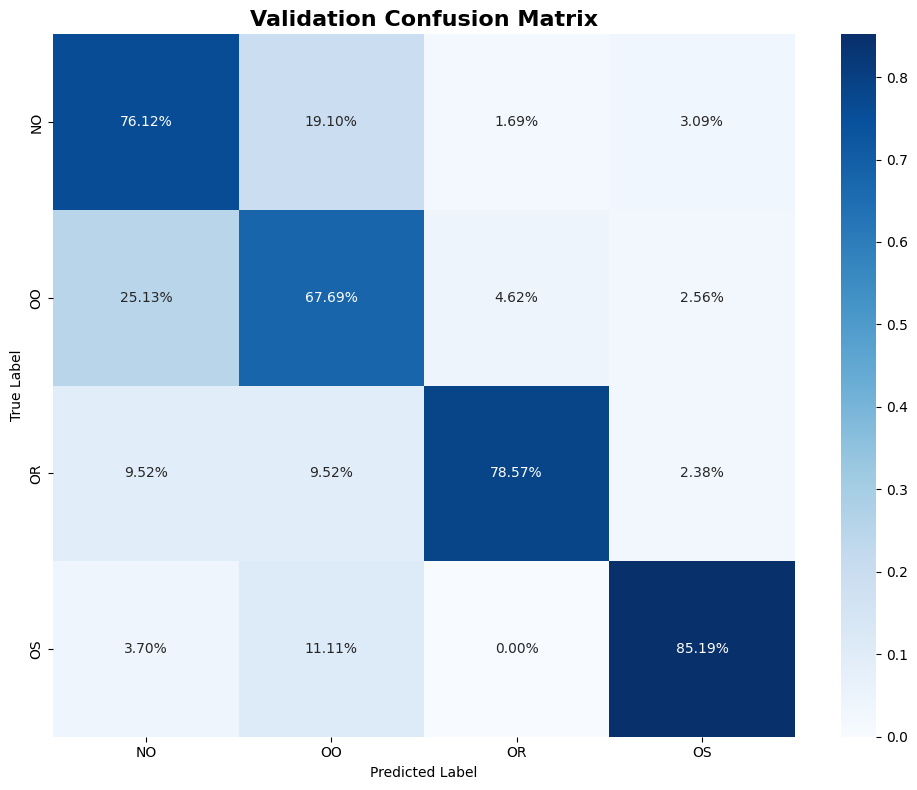


 TEST EVALUATION



Per-Class Test Results:
NO                  : Accuracy=0.7433, F1=0.7771, Support=896
OO                  : Accuracy=0.6317, F1=0.6165, Support=486
OR                  : Accuracy=0.5306, F1=0.4228, Support=49
OS                  : Accuracy=0.4737, F1=0.2687, Support=19

              precision    recall  f1-score   support

          NO     0.8142    0.7433    0.7771       896
          OO     0.6020    0.6317    0.6165       486
          OR     0.3514    0.5306    0.4228        49
          OS     0.1875    0.4737    0.2687        19

    accuracy                         0.6952      1450
   macro avg     0.4887    0.5948    0.5213      1450
weighted avg     0.7192    0.6952    0.7046      1450



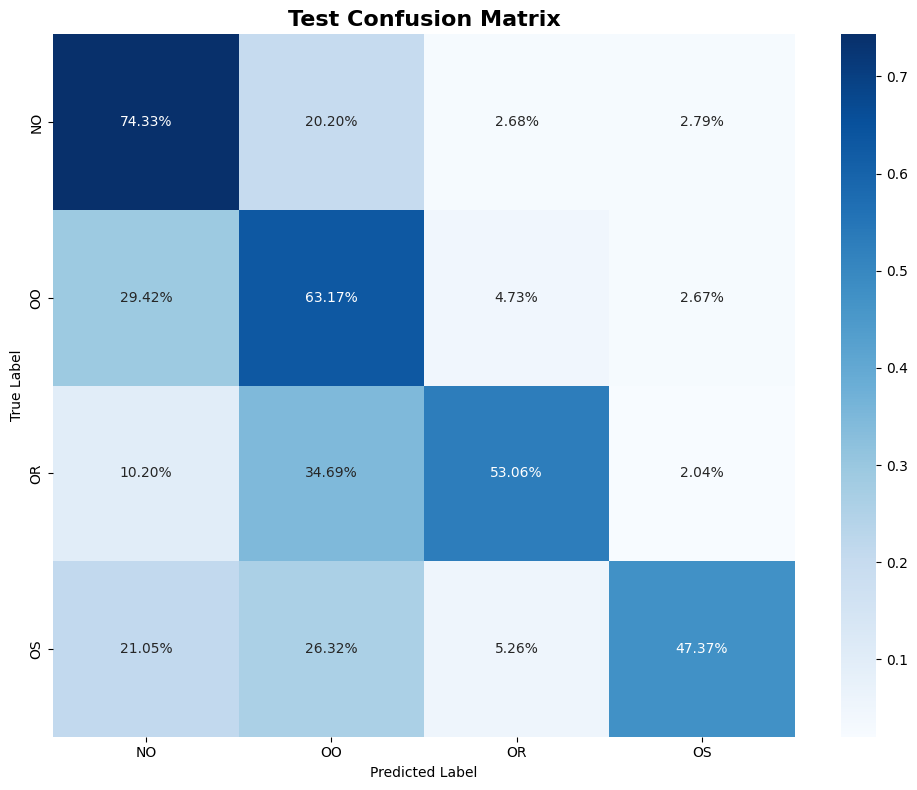


 TRAINING HISTORY


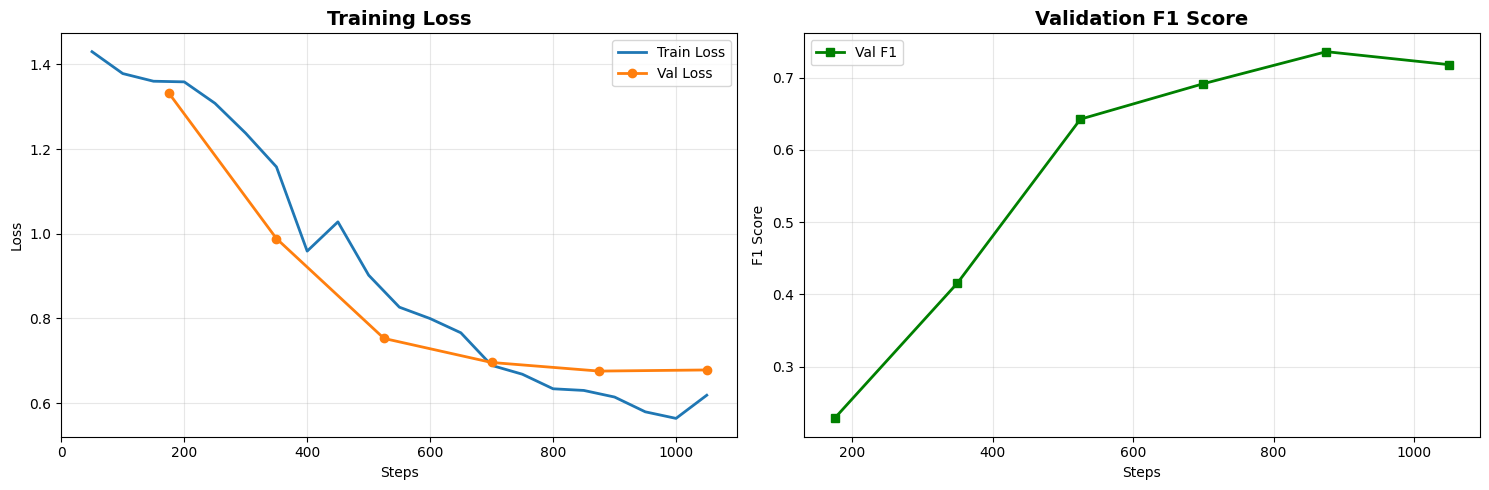


 FINAL RESULTS
Model: XLM-RoBERTa-large
Strategy: standard

Test Accuracy:  0.6952
Test Precision: 0.4887
Test Recall:    0.5948
Test Macro F1:  0.5213

Per-Class F1:
  ✅ NO: 0.7771
  ✅ OO: 0.6165
  ✅ OR: 0.4228
  ⚠️ OS: 0.2687

🎉 Training complete! Results saved to /kaggle/working/xlm_roberta_results

 UPLOADING TO HUGGING FACE

🔐 Logging in to Hugging Face...
✓ Login successful!
✓ Model card created
✓ Training config saved

📤 Uploading model to: UDHOV/xlm-roberta-large-nepali-hate-classification


README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

No files have been modified since last commit. Skipping to prevent empty commit.


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

No files have been modified since last commit. Skipping to prevent empty commit.


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            


✅ SUCCESSFULLY UPLOADED TO HUGGING FACE!

🎉 Your model is now available at:
   https://huggingface.co/UDHOV/xlm-roberta-large-nepali-hate-classification

📝 You can now use it for inference with:
   model = AutoModelForSequenceClassification.from_pretrained("UDHOV/xlm-roberta-large-nepali-hate-classification")
   tokenizer = AutoTokenizer.from_pretrained("UDHOV/xlm-roberta-large-nepali-hate-classification")


In [3]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, 
    confusion_matrix, classification_report
)

import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.filterwarnings('ignore')
from huggingface_hub import HfApi, login
# Set random seeds
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
set_seed(42)

print("✓ All imports successful")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


# ============================================================================
# GLOBAL CONFIGURATION
# ============================================================================

# Model selection: "base" or "large"
MODEL_SIZE = "large"  # Change to "large" for better results

# Training hyperparameters
BASE_LR = 1e-5
NUM_EPOCHS = 6
SEED = 42
OUTPUT_DIR = '/kaggle/working/xlm_roberta_results'
TRAINING_STRATEGY = "standard"  # "discriminative" or "standard"

# Model-specific configurations
MODEL_CONFIGS = {
    "base": {
        "name": "xlm-roberta-base",
        "batch_size": 16,
        "max_length": 256,
        "gradient_accumulation_steps": 2
    },
    "large": {
        "name": "xlm-roberta-large",
        "batch_size": 8,  # Smaller batch for large model
        "max_length": 256,
        "gradient_accumulation_steps": 4  # More accumulation for large model
    }
}

# Get current model config
current_config = MODEL_CONFIGS[MODEL_SIZE]
model_name = current_config["name"]
BATCH_SIZE = current_config["batch_size"]
MAX_LENGTH = current_config["max_length"]
GRAD_ACCUM_STEPS = current_config["gradient_accumulation_steps"]

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("\n" + "="*70)
print(" CONFIGURATION")
print("="*70)
print(f"Model: {MODEL_SIZE} ({model_name})")
print(f"Batch size: {BATCH_SIZE}")
print(f"Max length: {MAX_LENGTH}")
print(f"Gradient accumulation: {GRAD_ACCUM_STEPS}")
print(f"Learning rate: {BASE_LR}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Strategy: {TRAINING_STRATEGY}")


# ============================================================================
# SECTION 2: PREPROCESSING UTILITIES
# ============================================================================

import re
import emoji
import regex
from indic_transliteration import sanscript
from indic_transliteration.sanscript import transliterate

NEPALI_STOPWORDS = set([
    "र", "मा", "कि", "भने", "त", "छ", "हो", "लाई", "ले",
    "गरेको", "गर्छ", "गर्छन्", "हुन्", "गरे", "न", "नभएको",
    "को", "का", "की", "ने", "पनि", "नै", "थियो", "थिए"
])

DIRGHIKARAN_MAP = {
    "उ": "ऊ", "इ": "ई", "ऋ": "रि", "ए": "ऐ", "अ": "आ",
    "\u200d": "", "\u200c": "", "।": ".", "॥": ".",
    "ि": "ी", "ु": "ू"
}

def is_devanagari(text: str) -> bool:
    if not isinstance(text, str) or not text.strip():
        return False
    return bool(regex.search(r'\p{Devanagari}', text))

def devanagari_to_roman(text: str) -> str:
    try:
        return transliterate(text, sanscript.DEVANAGARI, sanscript.ITRANS)
    except:
        return text

def roman_to_devanagari(text: str) -> str:
    try:
        return transliterate(text, sanscript.ITRANS, sanscript.DEVANAGARI)
    except:
        return text

def normalize_dirghikaran(text: str) -> str:
    for original, replacement in DIRGHIKARAN_MAP.items():
        text = text.replace(original, replacement)
    return text

def clean_text(text: str, aggressive: bool = False) -> str:
    if not isinstance(text, str):
        return ""
    
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"@\w+|#\w+", "", text)
    text = emoji.replace_emoji(text, replace="")
    
    if aggressive:
        text = re.sub(r"\d+", "", text)
        text = re.sub(r"[^\w\s\u0900-\u097F]", "", text)
    
    text = re.sub(r"\s+", " ", text).strip()
    return text

def preprocess_for_transformer(text: str) -> str:
    if not isinstance(text, str):
        return ""
    
    if not is_devanagari(text):
        text = roman_to_devanagari(text)
    
    text = clean_text(text, aggressive=False)
    text = normalize_dirghikaran(text)
    
    return text

print("✓ Preprocessing utilities loaded")


# ============================================================================
# SECTION 3: DATASET 
# ============================================================================

class nepalihateeDataset(Dataset):
    """Dataset with configurable max_length"""
    
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx]) if self.texts[idx] else ""
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


# ============================================================================
# SECTION 4: CUSTOM TRAINER WITH CLASS WEIGHTS
# ============================================================================

class WeightedTrainer(Trainer):
    """Trainer with class weights in loss"""
    
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
    
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        if self.class_weights is not None:
            loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        else:
            loss = outputs.loss
        
        return (loss, outputs) if return_outputs else loss


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='macro', zero_division=0
    )
    
    return {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1)
    }

print("✓ Trainer defined")


# ============================================================================
# SECTION 5: LOAD DATA
# ============================================================================

print("\n" + "="*70)
print(" LOADING DATA")
print("="*70)

train_df = pd.read_json("/kaggle/input/nepalihatee/train_final.json")
val_df = pd.read_json("/kaggle/input/nepalihatee/val_final.json")
test_df = pd.read_json("/kaggle/input/nepalihatee/test.json")

print(f"\n✓ Data loaded:")
print(f"  Train: {len(train_df)}")
print(f"  Validation: {len(val_df)}")
print(f"  Test: {len(test_df)}")

print("\nTraining distribution:")
for label in sorted(train_df['Label_Multiclass'].unique()):
    count = (train_df['Label_Multiclass'] == label).sum()
    pct = count / len(train_df) * 100
    print(f"  {label}: {count} ({pct:.2f}%)")

# Preprocess
print("\nPreprocessing texts...")
for df in [train_df, val_df, test_df]:
    df['transformer_input'] = df['Comment'].apply(preprocess_for_transformer)

print("✓ Preprocessing complete")

# Label encoding
le = LabelEncoder()
le.fit(train_df['Label_Multiclass'])

y_train = le.transform(train_df['Label_Multiclass'])
y_val = le.transform(val_df['Label_Multiclass'])
y_test = le.transform(test_df['Label_Multiclass'])

label_names = le.classes_.tolist()
num_classes = len(label_names)

print(f"\n✓ Labels encoded: {label_names}")


# ============================================================================
# SECTION 6: COMPUTE CLASS WEIGHTS
# ============================================================================

print("\n" + "="*70)
print(" COMPUTING CLASS WEIGHTS")
print("="*70)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

print(f"\nBase balanced weights:")
for name, w in zip(label_names, class_weights):
    print(f"  {name}: {w:.2f}")

# Moderate boost
os_idx = label_names.index('OS') if 'OS' in label_names else None
or_idx = label_names.index('OR') if 'OR' in label_names else None

if os_idx is not None:
    class_weights[os_idx] *= 1.2
if or_idx is not None:
    class_weights[or_idx] *= 1.1

print(f"\nAfter boost:")
for name, w in zip(label_names, class_weights):
    print(f"  {name}: {w:.2f}")

# Cap weights
class_weights = np.clip(class_weights, 0.5, 5.0)

print(f"\nFinal weights (capped 0.5-5.0):")
for name, w in zip(label_names, class_weights):
    print(f"  {name}: {w:.2f}")

max_weight = class_weights.max()
min_weight = class_weights.min()
ratio = max_weight / min_weight

print(f"\nWeight ratio: {ratio:.1f}:1")
if ratio > 10:
    print("  ⚠️  WARNING: High ratio may cause instability!")
elif ratio > 6:
    print("  ⚠️  Monitor training carefully")
else:
    print("  ✅ Safe ratio")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)


# ============================================================================
# SECTION 7: INITIALIZE MODEL & TOKENIZER
# ============================================================================

print("\n" + "="*70)
print(" INITIALIZING MODEL & TOKENIZER")
print("="*70)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    use_fast=True,
    trust_remote_code=True
)
print(f"✓ Tokenizer loaded: {model_name}")

# Create datasets with configured max_length
train_dataset = nepalihateeDataset(
    train_df['transformer_input'].tolist(),
    y_train,
    tokenizer,
    max_length=MAX_LENGTH
)

val_dataset = nepalihateeDataset(
    val_df['transformer_input'].tolist(),
    y_val,
    tokenizer,
    max_length=MAX_LENGTH
)

test_dataset = nepalihateeDataset(
    test_df['transformer_input'].tolist(),
    y_test,
    tokenizer,
    max_length=MAX_LENGTH
)

print(f"✓ Datasets created: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")

# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_classes,
    problem_type="single_label_classification",
    ignore_mismatched_sizes=True,
    id2label={i: lab for i, lab in enumerate(label_names)},
    label2id={lab: i for i, lab in enumerate(label_names)}
)

# Enhanced regularization
if hasattr(model, "classifier") and hasattr(model.classifier, "dropout"):
    model.classifier.dropout = nn.Dropout(0.3)
if hasattr(model.config, "hidden_dropout_prob"):
    model.config.hidden_dropout_prob = 0.3
if hasattr(model.config, "attention_probs_dropout_prob"):
    model.config.attention_probs_dropout_prob = 0.2

# Enable gradient checkpointing for memory efficiency
if hasattr(model, "gradient_checkpointing_enable"):
    model.gradient_checkpointing_enable()

print(f"✓ Model loaded: {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"✓ All layers trainable")


# ============================================================================
# SECTION 8: TRAINING FUNCTIONS
# ============================================================================

def get_discriminative_optimizer(model, base_lr=1e-5):
    """
    Discriminative learning rates: slower for lower layers, faster for classifier
    Works for both base and large models
    """
    no_decay = ["bias", "LayerNorm.weight"]
    
    optimizer_grouped_parameters = [
        # Embeddings: 10% of base LR
        {
            "params": [p for n, p in model.named_parameters() 
                      if "embeddings" in n and not any(nd in n for nd in no_decay) and p.requires_grad],
            "lr": base_lr * 0.1,
            "weight_decay": 0.01
        },
        {
            "params": [p for n, p in model.named_parameters() 
                      if "embeddings" in n and any(nd in n for nd in no_decay) and p.requires_grad],
            "lr": base_lr * 0.1,
            "weight_decay": 0.0
        },
        # Encoder layers: 100% of base LR
        {
            "params": [p for n, p in model.named_parameters() 
                      if "embeddings" not in n and "classifier" not in n 
                      and not any(nd in n for nd in no_decay) and p.requires_grad],
            "lr": base_lr,
            "weight_decay": 0.01
        },
        {
            "params": [p for n, p in model.named_parameters() 
                      if "embeddings" not in n and "classifier" not in n 
                      and any(nd in n for nd in no_decay) and p.requires_grad],
            "lr": base_lr,
            "weight_decay": 0.0
        },
        # Classifier: 200% of base LR
        {
            "params": [p for n, p in model.named_parameters() 
                      if "classifier" in n and not any(nd in n for nd in no_decay) and p.requires_grad],
            "lr": base_lr * 2.0,
            "weight_decay": 0.01
        },
        {
            "params": [p for n, p in model.named_parameters() 
                      if "classifier" in n and any(nd in n for nd in no_decay) and p.requires_grad],
            "lr": base_lr * 2.0,
            "weight_decay": 0.0
        }
    ]
    
    # Remove empty groups
    optimizer_grouped_parameters = [
        group for group in optimizer_grouped_parameters if len(group["params"]) > 0
    ]
    
    optimizer = torch.optim.AdamW(optimizer_grouped_parameters, eps=1e-8)
    
    print("\n✓ Discriminative optimizer created:")
    print(f"  Embeddings:  {base_lr * 0.1:.1e} (10% of base)")
    print(f"  Encoder:     {base_lr:.1e} (100% of base)")
    print(f"  Classifier:  {base_lr * 2.0:.1e} (200% of base)")
    
    return optimizer


def build_trainer(model, strategy="discriminative"):
    """Build trainer with specified strategy"""
    
    training_args = TrainingArguments(
        output_dir=os.path.join(OUTPUT_DIR, f"{MODEL_SIZE}_{strategy}"),
        num_train_epochs=NUM_EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE * 2,
        gradient_accumulation_steps=GRAD_ACCUM_STEPS,
        
        learning_rate=BASE_LR if strategy == "standard" else None,  # None for discriminative
        warmup_steps=300,
        weight_decay=0.1,
        max_grad_norm=1.0,
        lr_scheduler_type="cosine",
        
        label_smoothing_factor=0.1,
        
        eval_strategy="epoch",
        save_strategy="no",       # <- NO CHECKPOINTS
        save_total_limit=0,       # <- NO CHECKPOINT FILES
        metric_for_best_model="f1",
        load_best_model_at_end=False,   # <- because no checkpoints exist

        greater_is_better=True,
        
        logging_steps=50,
        report_to="none",
        
        fp16=torch.cuda.is_available(),
        dataloader_num_workers=0,
        seed=SEED,
        remove_unused_columns=False
    )
    
    if strategy == "discriminative":
        optimizer = get_discriminative_optimizer(model, base_lr=BASE_LR)
        trainer = WeightedTrainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics,
            class_weights=class_weights_tensor,
            optimizers=(optimizer, None),
            callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
        )
        print("✓ Using DISCRIMINATIVE learning rates")
    else:
        trainer = WeightedTrainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics,
            class_weights=class_weights_tensor,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
        )
        print("✓ Using STANDARD learning rates")
    
    return trainer


# ============================================================================
# SECTION 9: TRAIN MODEL
# ============================================================================

print("\n" + "="*70)
print(" STARTING TRAINING")
print("="*70)

trainer = build_trainer(model, strategy=TRAINING_STRATEGY)

print("\n🎯 Training started...")
train_result = trainer.train()

print("\n✅ Training completed!")
print(f"⏱️  Time: {train_result.metrics['train_runtime']:.2f}s")


# ============================================================================
# SECTION 10: SAVE MODEL
# ============================================================================

final_model_dir = os.path.join(OUTPUT_DIR, f'{MODEL_SIZE}_final')
os.makedirs(final_model_dir, exist_ok=True)

trainer.save_model(final_model_dir)
tokenizer.save_pretrained(final_model_dir)

import joblib
joblib.dump(le, os.path.join(final_model_dir, 'label_encoder.pkl'))

print(f"\n✓ Model saved to: {final_model_dir}")


# ============================================================================
# SECTION 11: VALIDATION EVALUATION
# ============================================================================

print("\n" + "="*70)
print(" VALIDATION EVALUATION")
print("="*70)

val_predictions = trainer.predict(val_dataset)
val_preds = np.argmax(val_predictions.predictions, axis=-1)
val_labels = np.array(val_predictions.label_ids)

precision_all, recall_all, f1_all, support_all = precision_recall_fscore_support(
    val_labels, val_preds, average=None, zero_division=0
)

print("\nPer-Class Validation Results:")
print("="*70)
for i, name in enumerate(label_names):
    mask = (val_labels == i)
    
    if mask.sum() > 0:
        class_acc = (val_preds[mask] == i).sum() / mask.sum()
    else:
        class_acc = 0.0
    
    print(f"{name:20s}: Accuracy={class_acc:.4f}, F1={f1_all[i]:.4f}, Support={int(support_all[i])}")

print("\n" + classification_report(val_labels, val_preds, target_names=label_names, digits=4))

# Validation Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(val_labels, val_preds)
cm_sum = cm.sum(axis=1, keepdims=True)
cm_sum[cm_sum == 0] = 1
cm_normalized = cm.astype(float) / cm_sum

sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names)
plt.title("Validation Confusion Matrix", fontsize=16, fontweight='bold')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, f"{MODEL_SIZE}_val_confusion_matrix.png"), dpi=300)
plt.show()


# ============================================================================
# SECTION 12: TEST EVALUATION
# ============================================================================

print("\n" + "="*70)
print(" TEST EVALUATION")
print("="*70)

test_predictions = trainer.predict(test_dataset)
test_preds = np.argmax(test_predictions.predictions, axis=-1)
test_labels = np.array(test_predictions.label_ids)

precision_all_t, recall_all_t, f1_all_t, support_all_t = precision_recall_fscore_support(
    test_labels, test_preds, average=None, zero_division=0
)

print("\nPer-Class Test Results:")
print("="*70)
for i, name in enumerate(label_names):
    mask = (test_labels == i)
    
    if mask.sum() > 0:
        class_acc = (test_preds[mask] == i).sum() / mask.sum()
    else:
        class_acc = 0.0
    
    print(f"{name:20s}: Accuracy={class_acc:.4f}, F1={f1_all_t[i]:.4f}, Support={int(support_all_t[i])}")

print("\n" + classification_report(test_labels, test_preds, target_names=label_names, digits=4))

# Test Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(test_labels, test_preds)
cm_sum = cm.sum(axis=1, keepdims=True)
cm_sum[cm_sum == 0] = 1
cm_normalized = cm.astype(float) / cm_sum

sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names)
plt.title("Test Confusion Matrix", fontsize=16, fontweight='bold')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, f"{MODEL_SIZE}_test_confusion_matrix.png"), dpi=300)
plt.show()


# ============================================================================
# SECTION 13: TRAINING HISTORY
# ============================================================================

if hasattr(trainer.state, 'log_history') and len(trainer.state.log_history) > 0:
    print("\n" + "="*70)
    print(" TRAINING HISTORY")
    print("="*70)
    
    logs = trainer.state.log_history
    
    train_losses = [log['loss'] for log in logs if 'loss' in log]
    train_steps = [log['step'] for log in logs if 'loss' in log]
    
    eval_losses = [log['eval_loss'] for log in logs if 'eval_loss' in log]
    eval_f1s = [log['eval_f1'] for log in logs if 'eval_f1' in log]
    eval_steps = [log['step'] for log in logs if 'eval_loss' in log]
    
    if train_losses:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        axes[0].plot(train_steps, train_losses, label='Train Loss', linewidth=2)
        if eval_losses:
            axes[0].plot(eval_steps, eval_losses, label='Val Loss', 
                        linewidth=2, marker='o', markersize=6)
        axes[0].set_title("Training Loss", fontsize=14, fontweight='bold')
        axes[0].set_xlabel("Steps")
        axes[0].set_ylabel("Loss")
        axes[0].grid(True, alpha=0.3)
        axes[0].legend()
        
        if eval_f1s:
            axes[1].plot(eval_steps, eval_f1s, label='Val F1', 
                        linewidth=2, marker='s', markersize=6, color='green')
            axes[1].set_title("Validation F1 Score", fontsize=14, fontweight='bold')
            axes[1].set_xlabel("Steps")
            axes[1].set_ylabel("F1 Score")
            axes[1].grid(True, alpha=0.3)
            axes[1].legend()
        
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, f"{MODEL_SIZE}_training_history.png"), dpi=300)
        plt.show()


# ============================================================================
# SECTION 14: SAVE FINAL RESULTS
# ============================================================================

test_accuracy = accuracy_score(test_labels, test_preds)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
    test_labels, test_preds, average="macro", zero_division=0
)

results = {
    "model": f"XLM-RoBERTa-{MODEL_SIZE}",
    "strategy": TRAINING_STRATEGY,
    "test_accuracy": float(test_accuracy),
    "test_precision": float(test_precision),
    "test_recall": float(test_recall),
    "test_f1": float(test_f1),
    "per_class_f1": {
        label_names[i]: float(f1_all_t[i]) for i in range(len(label_names))
    }
}

with open(os.path.join(OUTPUT_DIR, f"{MODEL_SIZE}_results.json"), "w") as f:
    json.dump(results, f, indent=2)

print("\n" + "="*70)
print(" FINAL RESULTS")
print("="*70)
print(f"Model: XLM-RoBERTa-{MODEL_SIZE}")
print(f"Strategy: {TRAINING_STRATEGY}")
print(f"\nTest Accuracy:  {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall:    {test_recall:.4f}")
print(f"Test Macro F1:  {test_f1:.4f}")
print("\nPer-Class F1:")
for name, f1 in results["per_class_f1"].items():
    status = "✅" if f1 > 0.30 else "⚠️" if f1 > 0.10 else "❌"
    print(f"  {status} {name}: {f1:.4f}")
print("="*70)

print(f"\n🎉 Training complete! Results saved to {OUTPUT_DIR}")

# ============================================================================
# SECTION 15: UPLOAD TO HUGGING FACE
# ============================================================================

print("\n" + "="*70)
print(" UPLOADING TO HUGGING FACE")
print("="*70)

# Configuration
HF_USERNAME = "UDHOV"
HF_MODEL_NAME = f"xlm-roberta-{MODEL_SIZE}-nepali-hate-classification"
HF_REPO_ID = f"{HF_USERNAME}/{HF_MODEL_NAME}"

# Login to Hugging Face using Kaggle Secrets
print("\n🔐 Logging in to Hugging Face...")

try:
    # Get HF token from Kaggle Secrets
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    hf_token = user_secrets.get_secret("nepalihate")
    
    # Login with token
    login(token=hf_token)
    print("✓ Login successful!")
    
    # Create model card content
    model_card_content = f"""---
language:
- ne
license: apache-2.0
tags:
- hate-speech-detection
- nepali
- text-classification
- xlm-roberta
datasets:
- nepali-hate-speech
metrics:
- accuracy
- f1
- precision
- recall
library_name: transformers
---

# XLM-RoBERTa {MODEL_SIZE.upper()} - Nepali Hate Speech Classification

This model is fine-tuned on Nepali hate speech detection dataset using XLM-RoBERTa-{MODEL_SIZE}.

## Model Description

- **Model Type**: Sequence Classification
- **Base Model**: xlm-roberta-{MODEL_SIZE}
- **Language**: Nepali (ne)
- **Training Strategy**: {TRAINING_STRATEGY}
- **Task**: Multi-class Hate Speech Classification

## Labels

The model classifies text into the following categories:

{chr(10).join([f"- **{label}**" for label in label_names])}

## Performance

### Test Set Results

- **Accuracy**: {test_accuracy:.4f}
- **Macro F1**: {test_f1:.4f}
- **Precision**: {test_precision:.4f}
- **Recall**: {test_recall:.4f}

### Per-Class F1 Scores

{chr(10).join([f"- {name}: {f1:.4f}" for name, f1 in results['per_class_f1'].items()])}

## Usage

```python
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load model and tokenizer
model_name = "{HF_REPO_ID}"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Prepare input
text = "Your Nepali text here"
inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=256)

# Get prediction
with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predicted_class = torch.argmax(predictions, dim=-1).item()

# Get label
label_names = {label_names}
predicted_label = label_names[predicted_class]
confidence = predictions[0][predicted_class].item()

print(f"Predicted: {{predicted_label}} (confidence: {{confidence:.4f}})")
```

## Training Configuration

- **Batch Size**: {BATCH_SIZE}
- **Gradient Accumulation Steps**: {GRAD_ACCUM_STEPS}
- **Learning Rate**: {BASE_LR}
- **Epochs**: {NUM_EPOCHS}
- **Max Length**: {MAX_LENGTH}
- **Class Weights**: Applied for imbalanced classes

## Preprocessing

The model expects text preprocessed with:
- Devanagari normalization
- URL and mention removal
- Emoji removal
- Dirghikaran normalization

## Limitations

- Trained specifically on Nepali language hate speech data
- Performance may vary on out-of-domain text
- May require domain-specific fine-tuning for other applications

## Citation

If you use this model, please cite:

```bibtex
@misc{{xlm-roberta-nepali-hate,
  author = {{UDHOV}},
  title = {{XLM-RoBERTa {MODEL_SIZE.upper()} for Nepali Hate Speech Classification}},
  year = {{2024}},
  publisher = {{Hugging Face}},
  url = {{https://huggingface.co/{HF_REPO_ID}}}
}}
```

## Contact

For questions or feedback, please open an issue on the model repository.
"""

    # Save model card
    model_card_path = os.path.join(final_model_dir, "README.md")
    with open(model_card_path, "w", encoding="utf-8") as f:
        f.write(model_card_content)
    
    print(f"✓ Model card created")
    
    # Save training config as JSON
    training_config = {
        "model_size": MODEL_SIZE,
        "base_model": model_name,
        "training_strategy": TRAINING_STRATEGY,
        "batch_size": BATCH_SIZE,
        "gradient_accumulation_steps": GRAD_ACCUM_STEPS,
        "learning_rate": BASE_LR,
        "num_epochs": NUM_EPOCHS,
        "max_length": MAX_LENGTH,
        "class_weights": class_weights.tolist(),
        "label_names": label_names,
        "test_metrics": results
    }
    
    config_path = os.path.join(final_model_dir, "training_config.json")
    with open(config_path, "w") as f:
        json.dump(training_config, f, indent=2)
    
    print(f"✓ Training config saved")
    
    # Upload to Hugging Face
    print(f"\n📤 Uploading model to: {HF_REPO_ID}")
    
    # Push model to hub
    model.push_to_hub(
        HF_REPO_ID,
        use_temp_dir=True,
        commit_message=f"Upload XLM-RoBERTa-{MODEL_SIZE} Nepali hate speech model"
    )
    
    tokenizer.push_to_hub(
        HF_REPO_ID,
        use_temp_dir=True,
        commit_message=f"Upload tokenizer"
    )
    
    # Upload additional files
    api = HfApi()
    
    # Upload label encoder
    api.upload_file(
        path_or_fileobj=os.path.join(final_model_dir, "label_encoder.pkl"),
        path_in_repo="label_encoder.pkl",
        repo_id=HF_REPO_ID,
        commit_message="Add label encoder"
    )
    
    # Upload training config
    api.upload_file(
        path_or_fileobj=config_path,
        path_in_repo="training_config.json",
        repo_id=HF_REPO_ID,
        commit_message="Add training configuration"
    )
    
    # Upload confusion matrices
    for img_file in [f"{MODEL_SIZE}_val_confusion_matrix.png", 
                     f"{MODEL_SIZE}_test_confusion_matrix.png",
                     f"{MODEL_SIZE}_training_history.png"]:
        img_path = os.path.join(OUTPUT_DIR, img_file)
        if os.path.exists(img_path):
            api.upload_file(
                path_or_fileobj=img_path,
                path_in_repo=img_file,
                repo_id=HF_REPO_ID,
                commit_message=f"Add {img_file}"
            )
    
    print("\n" + "="*70)
    print("✅ SUCCESSFULLY UPLOADED TO HUGGING FACE!")
    print("="*70)
    print(f"\n🎉 Your model is now available at:")
    print(f"   https://huggingface.co/{HF_REPO_ID}")
    print("\n📝 You can now use it for inference with:")
    print(f'   model = AutoModelForSequenceClassification.from_pretrained("{HF_REPO_ID}")')
    print(f'   tokenizer = AutoTokenizer.from_pretrained("{HF_REPO_ID}")')
    print("="*70)

except Exception as e:
    print(f"\n❌ Error uploading to Hugging Face: {str(e)}")
    print("\nTroubleshooting:")
    print("1. Make sure you have a Hugging Face account")
    print("2. Create a token at: https://huggingface.co/settings/tokens")
    print("3. The token needs 'write' permission")
    print("4. You may need to install: pip install huggingface_hub")
    print("\nYour model is still saved locally at:")
    print(f"   {final_model_dir}")